# Bayes Factor for Gaussian Mixture Model

Consider two data sets. Do they come from the same parent distribution or not?

The classic approach is perform a KS test of the CDFs. The KS test has two big advantages:
1. It is nonparametric.
1. It can be applied to unbinned data of very different sizes.

The problem with the KS test is that provides evidence against the hypothesis that both data sets come from the same parent distribution (the null hypothesis), and thus can be biased against this hypothesis. Moreover, the test is mainly sensitive to differences in the centers of the distributions rather than the tails. Other frequentist tests like the [Anderson-Darling test](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35e.htm) attempt to rectify this.

However, if we know that our data are distributed like one or more Gaussians (a Gaussian mixture model) we can bin and fit the data to the model assuming the samples come from the same parent distribution, as well two different parent distributions. We'll call the models $\mathcal{M}_1$ and $\mathcal{M}_2$, respectively. Then the two models can be compared using a likelihood ratio test or a Bayes Factor.

The Bayes Factor is a nice approach because it automatically penalizes more complicated fits. It provides a convenient model comparison in terms of an odds ratio and enables marginalization of nuisance parameters. It also does not require that model $\mathcal{M}_1$ and $\mathcal{M}_2$ be nested, as required when using Wilks' Theorem to convert a likelihood ratio to a $\chi^2$ p-value. The conventional interpretation of the Bayes Factor is discussed in [Kass and Raftery, 1995](https://amstat.tandfonline.com/doi/abs/10.1080/01621459.1995.10476572).

This notebook generates two synthetic data sets **from different parent distributions**, though the data sets have the same size. It then performs a Gaussian mixture fit assuming Poisson uncertainties and demonstrates both maximum likelihood fits and Bayesian analysis using nested sampling. Finally, the Bayes Factor of the two models is computed 

In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import norm, ks_2samp
from scipy.integrate import trapz, cumtrapz
from scipy.interpolate import PchipInterpolator
from scipy.special import gammaln
from scipy.optimize import minimize

import numdifftools as ndt

import dynesty
from dynesty import plotting as dyplot

mpl.rc('font', size=16)

## Model Generation

Set up a Gaussian mixture model and generate random data from the model.

In [5]:
def model(params, x):
    """Gaussian mixture model.
    
    Parameters
    ----------
    params : list or tuple
        A list of lists containing N Gaussian parameters (ampl, mu, sigma).
    x : float or ndarray
        Values used to calculate the model PDF.
        
    Returns
    -------
    model : float or ndarray
        Output PDF as a function of x.
    """
    N = len(params)
    return np.sum([params[i][0] * norm.pdf(x, loc=params[i][1], scale=params[i][2]) for i in range(N)], axis=0)

def get_inv_cdf(x, pdfx):
    """Given a PDF f(x), return the inverse CDF F^-1(x).
    
    Parameters
    ----------
    x : ndarray
        Table of values used to calculate the model PDF.
    pdfx : ndarray
        Table of values giving the PDF vs. x.
        
    Returns
    -------
    inv_cdf : PchipInterpolator
        Inverse of the CDF, callable as a function.
    """
    cdf = cumtrapz(pdfx, x) / trapz(pdfx, x)
    cdf = np.insert(cdf, 0, 0)
    cdf[-1] = 1.
    return PchipInterpolator(cdf/cdf[-1], x)

### Data Creation

Generate two data sets from the same parent distribution. Plot the PDFs and CDFs.

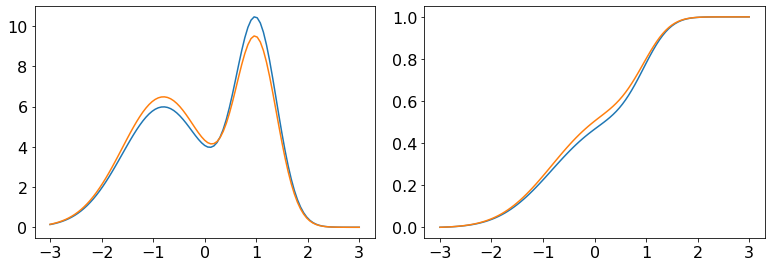

In [6]:
N = 101
x = np.linspace(-3,3, N)
lmbda1 = model([[12,-0.8,0.8], [10,1,0.4]], x)
lmbda2 = model([[13,-0.8,0.8], [9,1,0.4]], x)

cdf1 = np.cumsum(lmbda1)
cdf1 /= cdf1[-1]
cdf2 = np.cumsum(lmbda2)
cdf2 /= cdf2[-1]

fig, axes = plt.subplots(1,2, figsize=(11,4), sharex=True, tight_layout=True)
ax = axes[0]
ax.plot(x, lmbda1)
ax.plot(x, lmbda2)
ax = axes[1]
ax.plot(x, cdf1)
ax.plot(x, cdf2);

Create inverse CDF function.

In [7]:
inv_cdf1 = get_inv_cdf(x, lmbda1)
inv_cdf2 = get_inv_cdf(x, lmbda2)

Use the inverse CDF to generate random data from the distribution. Make the second data set 60% as large as the first data set.

In [12]:
data1 = inv_cdf1(np.random.uniform(0.,1.,size=20000))
data2 = inv_cdf2(np.random.uniform(0.,1.,size=20000))

Histogram the data (left) and show normalized histograms (right).

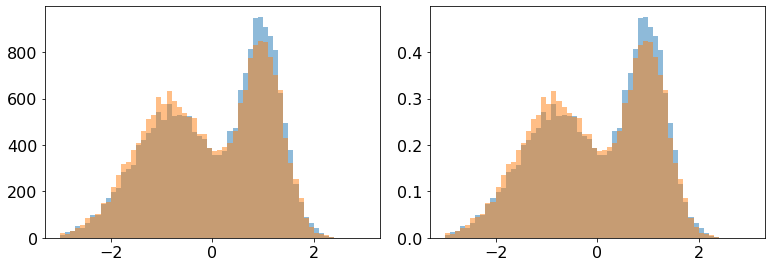

In [13]:
fig, axes = plt.subplots(1,2, figsize=(11,4), sharex=True, tight_layout=True)

ax = axes[0]
ax.hist(data1, bins=np.linspace(-3,3,61), alpha=0.5)
ax.hist(data2, bins=np.linspace(-3,3,61), alpha=0.5)

ax = axes[1]
ax.hist(data1, bins=np.linspace(-3,3,61), alpha=0.5, density=True)
ax.hist(data2, bins=np.linspace(-3,3,61), alpha=0.5, density=True);

### Create Binned Data Sets

Histogram the sets to create two binned data sets used for fitting below.

<ErrorbarContainer object of 3 artists>

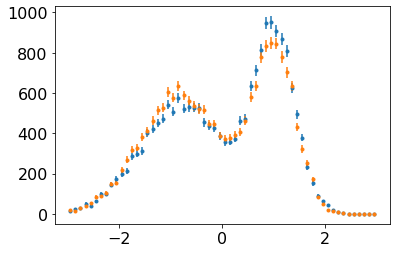

In [14]:
density = False

n1, edges1 = np.histogram(data1, bins=np.linspace(-3,3,61))
dn1 = np.sqrt(n1)
x = 0.5*(edges1[1:] + edges1[:-1])
if density:
    N1 = np.trapz(n1, x1)
    n1, dn1 = n1/N1, dn1/N1
plt.errorbar(x, n1, yerr=dn1, fmt='.')

n2, edges2 = np.histogram(data2, bins=np.linspace(-3,3,61))
dn2 = np.sqrt(n2)
# x = 0.5*(edges2[1:] + edges2[:-1])
if density:
    N2 = np.trapz(n2, x2)
    n2, dn2 = n2/N2, dn2/N2
plt.errorbar(x, n2, yerr=dn2, fmt='.')

### KS Test

Apply the KS test just to see what the result looks like.

In [15]:
ks, p = ks_2samp(data1, data2)
ks, p

(0.04170000000000007, 1.574792591186679e-15)

The KS p-value is about $10^{-15}$, so the KS test identifies the data as coming from different parent distributions. More correctly, we would say that the KS test statistic is inconsistent with the null hypothesis of one parent distribution.

## Model $\mathcal{M}_1$: Single Parent Distribution

We have two data sets with binned counts $\mathbf{m}={m_i}$ and $\mathbf{n}={n_i}$. Assume both data sets are created by the same Gaussian mixture model such that the mean count in bin $i$ for data set 1 is

$$
  \lambda_{1,i} = \left[\alpha\mathcal{N}(\mu_\alpha,\sigma_\alpha) + \beta\mathcal{N}(\mu_\beta,\sigma_\beta)\right]_i.
$$

To account for the different sizes in the data sets, we can add a scale factor $s$ to the fit to the second data set:

$$
  \lambda_{2,i} = \left[s\left(\alpha\mathcal{N}(\mu_\alpha,\sigma_\alpha) + \beta\mathcal{N}(\mu_\beta,\sigma_\beta)\right)\right]_i = s\lambda_{1,i}.
$$

Thus the model includes 7 parameters $\theta=\left\{s,\alpha,\mu_\alpha,\sigma_\alpha,\beta,\mu_\beta,\sigma_\beta\right\}$.

### Maximum Likelihood Result

We want to maximize the joint Poisson likelihood

$$
  p(\mathbf{m},\mathbf{n}|\lambda_1,\lambda_2,\mathcal{M_1})
  = \prod_{i=1}^N \frac{\lambda_{1,i}^{m_i}e^{-\lambda_{1,i}}}{m_i!}
  \frac{\lambda_{2,i}^{n_i}e^{-\lambda_{2,i}}}{n_i!},
$$

or minimize the negative log likelihood

$$
-\ln{\mathcal{L}} = -\sum_{i=1}^N \left(m_i\lambda_{1,i}-\lambda_{1,i}-\ln{m_i!} + 
n_i\lambda_{2,i}-\lambda_{2,i}-\ln{n_i!}\right).
$$

In [16]:
def mixturemodel(params, x):
    """Mixture of two Gaussians.
    
    Parameters
    ----------
    params : list or ndarray
        List of parameters (expect 2x3).
    x : float or ndarray
        Values to calculate the model.
    
    Returns
    -------
    model : float or ndarray
        Mixture model evaluated at x.
    """
    a, mu_a, sigma_a = params[:3]
    b, mu_b, sigma_b = params[3:]
    return a*norm.pdf(x, loc=mu_a, scale=sigma_a) + b*norm.pdf(x, loc=mu_b, scale=sigma_b)

def logLjoint1(params, m, n, x):
    """Joint log-likelihood of the two data sets.
    
    Parameters
    ----------
    params : list or ndarray
        List of 7 parameters: 2x3 Gaussian pars + scale factor.
    m : ndarray
        Binned counts in data set 1.
    n : ndarray
        Binned counts in data set 2.
    x : ndarray
        Bin centers used to construct the histogrammed counts m and n.
        
    Returns
    -------
    logL : float
        Log likelihood of sets m and n given model parameters.
    """
    s, gausspars = params[0], params[1:]
    lambda1 = mixturemodel(gausspars, x)
    lambda2 = s*lambda1
    return np.sum(m*np.log(lambda1) - lambda1 - gammaln(m+1) + n*np.log(lambda2) - lambda2 - gammaln(n+1))

def nlogLjoint1(params, m, n, x):
    """Negative log-likelihood, for minimizers."""
    return -logLjoint1(params, m, n, x)

#### Maxmize the Likelihood

Find the maximum likelihood parameters of model $\mathcal{M}_1$ by minimizing $-\ln{\mathcal{L}}$.

Perform a bounded fit using the L-BFGS-B algorithm.

In [22]:
# Parameter bounds.
bounds1 = [[0.1,10.],      # s ........ Gaussian 1 to 2 scale factor
           [500., 2000.],  # a ........ Gaussian 1 amplitude
           [-3., 0.],      # mu_a ..... Gaussian 1 location
           [0.1, 3.],      # sigma_a .. Gaussian 1 scale
           [500., 2000.],  # b ........ Gaussian 2 amplitude
           [0., 3.],       # mu_b ..... Gaussian 2 location
           [0.1, 3.]]      # sigma_b .. Gaussian 2 scale

# Generate 10 random seeds for the minimizer.
# Store the result with the lowest -ln(L) in bestfit.
bestfit = None

for i in range(10):
    p0 = [np.random.uniform(b[0], b[1]) for b in bounds1]
    result = minimize(nlogLjoint1, p0, method='L-BFGS-B', args=(n1, n2, x), bounds=bounds1)
    
    if result.success:
        print(p0)
        print('  {:.2f}'.format(result.fun))
        if bestfit is None:
            bestfit = result
        else:
            if result.fun < bestfit.fun:
                bestfit = result

bestfit

[5.258523680787991, 1014.0865906348519, -2.4043975298139193, 2.752924971587012, 1164.4451530156443, 0.5388160379571113, 0.9715272405111974]
  480.32
[4.641367714097642, 1001.6525022430425, -2.5997973073244753, 2.4471083645254774, 1387.5676636136182, 1.8459492539313167, 0.37782860458691825]
  480.32
[7.4243176206104895, 1792.863777937763, -1.50067459653128, 0.20216183502775004, 1969.7195957532638, 0.7537877866027514, 0.5299022251989527]
  480.32
[1.4783176886711284, 671.2429538721161, -1.210864374516749, 2.5506402426106374, 1910.8571463689877, 2.265172732912679, 1.1724787735450615]
  480.32
[5.186737768489942, 1815.7984429920277, -2.1621738188446304, 0.8587345245669576, 895.019978625144, 2.96002061103124, 2.0754352188810126]
  480.32
[6.57952144265777, 622.7649110824494, -1.8446621342628755, 2.7361480938747187, 668.1803211935526, 1.204858184459889, 0.1288359062909465]
  480.32
[8.492855341621757, 613.6794985853409, -0.18699796264777113, 2.827348011420709, 838.8263156830009, 0.7569845462

      fun: 480.32118308854933
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.89945853e-02, -6.25277607e-05,  1.11242571e-02,  6.17035312e-02,
       -4.54747351e-05,  1.58019020e-01,  2.08444817e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 904
      nit: 71
   status: 0
  success: True
        x: array([ 9.99993295e-01,  1.13942671e+03, -8.02350295e-01,  8.03821558e-01,
        8.64137798e+02,  1.00757386e+00,  4.00732560e-01])

#### Plot Maximum Likelihood Fit

Plot the best fit results on top of the binned data.

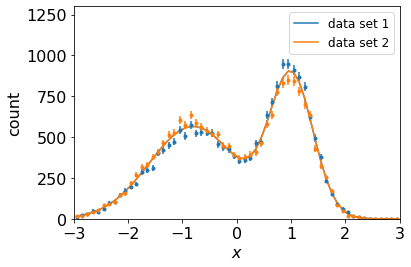

In [23]:
fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)

ep = ax.errorbar(x, n1, yerr=dn1, fmt='.')
ax.plot(x, mixturemodel(bestfit.x[1:], x), color=ep[0].get_color(), label='data set 1')

ep = ax.errorbar(x, n2, yerr=dn1, fmt='.');
ax.plot(x, bestfit.x[0]*mixturemodel(bestfit.x[1:], x), color=ep[0].get_color(), label='data set 2')

ax.set(xlim=(-3,3),
       xlabel='$x$',
       ylim=(0, 1300),
       ylabel='count')

ax.legend(fontsize=12);

#### Compute ML Parameter Uncertainties

Use the `numdifftools` library to compute the Hessian of the likelihood function, and from that the parameter uncertainties.

In [24]:
negloglike1 = lambda params: nlogLjoint1(params, n1, n2, x)

hessian = ndt.Hessian(negloglike1)
h = hessian(bestfit.x)

# Invert the Hessian matrix and compute the square root of the diagonals.
hinv = np.linalg.inv(h)
uncertainty = np.sqrt(np.diag(hinv))

/Users/sybenzvi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in log
/Users/sybenzvi/anaconda3/lib/python3.7/site-packages/numdifftools/extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/sybenzvi/anaconda3/lib/python3.7/site-packages/numdifftools/limits.py:173: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/sybenzvi/anaconda3/lib/python3.7/site-packages/numdifftools/limits.py:174: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/sybenzvi/anaconda3/lib/python3.7/site-packages/numdifftools/limits.py:175: RuntimeWarning: invalid value encountered in less
  ((der < p25 - 1.5 * iqr) + (p75 + 1.5 * iqr < der)))


In [25]:
labels = ['$s$', '$a$', r'$\mu_a$', r'$\sigma_a$', '$b$', r'$\mu_b$', r'$\sigma_b$']
for i in range(7):
    print('{:<10s} = {:7.2f} +- {:.2f}'.format(labels[i], bestfit.x[i], uncertainty[i]))

$s$        =    1.00 +- 0.01
$a$        = 1139.43 +- 11.98
$\mu_a$    =   -0.80 +- 0.01
$\sigma_a$ =    0.80 +- 0.01
$b$        =  864.14 +- 10.67
$\mu_b$    =    1.01 +- 0.00
$\sigma_b$ =    0.40 +- 0.00


### Nested Sampling of the Likelihood and Priors

Use the `dynesty` nested sampler to generate samples from the posterior PDF

$$
p(\vec{\theta},\mathcal{M}_1|\mathbf{m},\mathbf{n}) \propto p(\mathbf{m},\mathbf{n}|\vec{\theta},\mathcal{M}_1)\ 
p(\vec{\theta}|\mathcal{M}_1)
$$

where $\vec{\theta}=(s,\alpha,\mu_\alpha,\sigma_\alpha,\beta,\mu_\beta,\sigma_\beta)$ is the list of parameters in the model. We can assume the prior probability of the parameters

$$
p(\vec{\theta}|\mathcal{M}_1)
$$

is the product of 7 independent distributions for the 7 parameters. See below for implementation.

In [26]:
def uniform(a, b, u):
    """Given u in [0,1], return a uniform number in [a,b]."""
    return a + (b-a)*u

def jeffreys(a, b, u):
    """Given u in [0,1], return a Jeffreys random number in [a,b]."""
    return a**(1-u) * b**u

def prior_xform1(u):
    """Priors for the 7 parameters of model M1. Required by the dynesty sampler.
    
    Parameters
    ----------
    u : ndarray
        Array of uniform random numbers between 0 and 1.
        
    Returns
    -------
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    """
    s       = uniform(0.2, 2., u[0])
    a       = jeffreys(1., 1e4, u[1])
    mu_a    = uniform(-3., 0., u[2])
    sigma_a = jeffreys(0.1, 1., u[3])
    b       = jeffreys(1., 1e4, u[4])
    mu_b    = uniform(0., 3., u[5])
    sigma_b = jeffreys(0.1, 1., u[6])
    
    return s, a, mu_a, sigma_a, b, mu_b, sigma_b

#### Run the Nested Sampler

In [28]:
dsampler = dynesty.DynamicNestedSampler(logLjoint1, prior_xform1, ndim=7,
                                        logl_args=(n1, n2, x),
                                        nlive=1000,
                                        bound='multi',
                                        sample='auto')

dsampler.run_nested()
dres1 = dsampler.results

35775it [06:07, 97.27it/s, batch: 8 | bound: 200 | nc: 1 | ncall: 173408 | eff(%): 20.631 | loglstar: -489.056 < -480.631 < -483.004 | logz: -516.179 +/-  0.350 | stop:  0.897]            


#### Produce a Corner Plot of the Best Fit Parameters

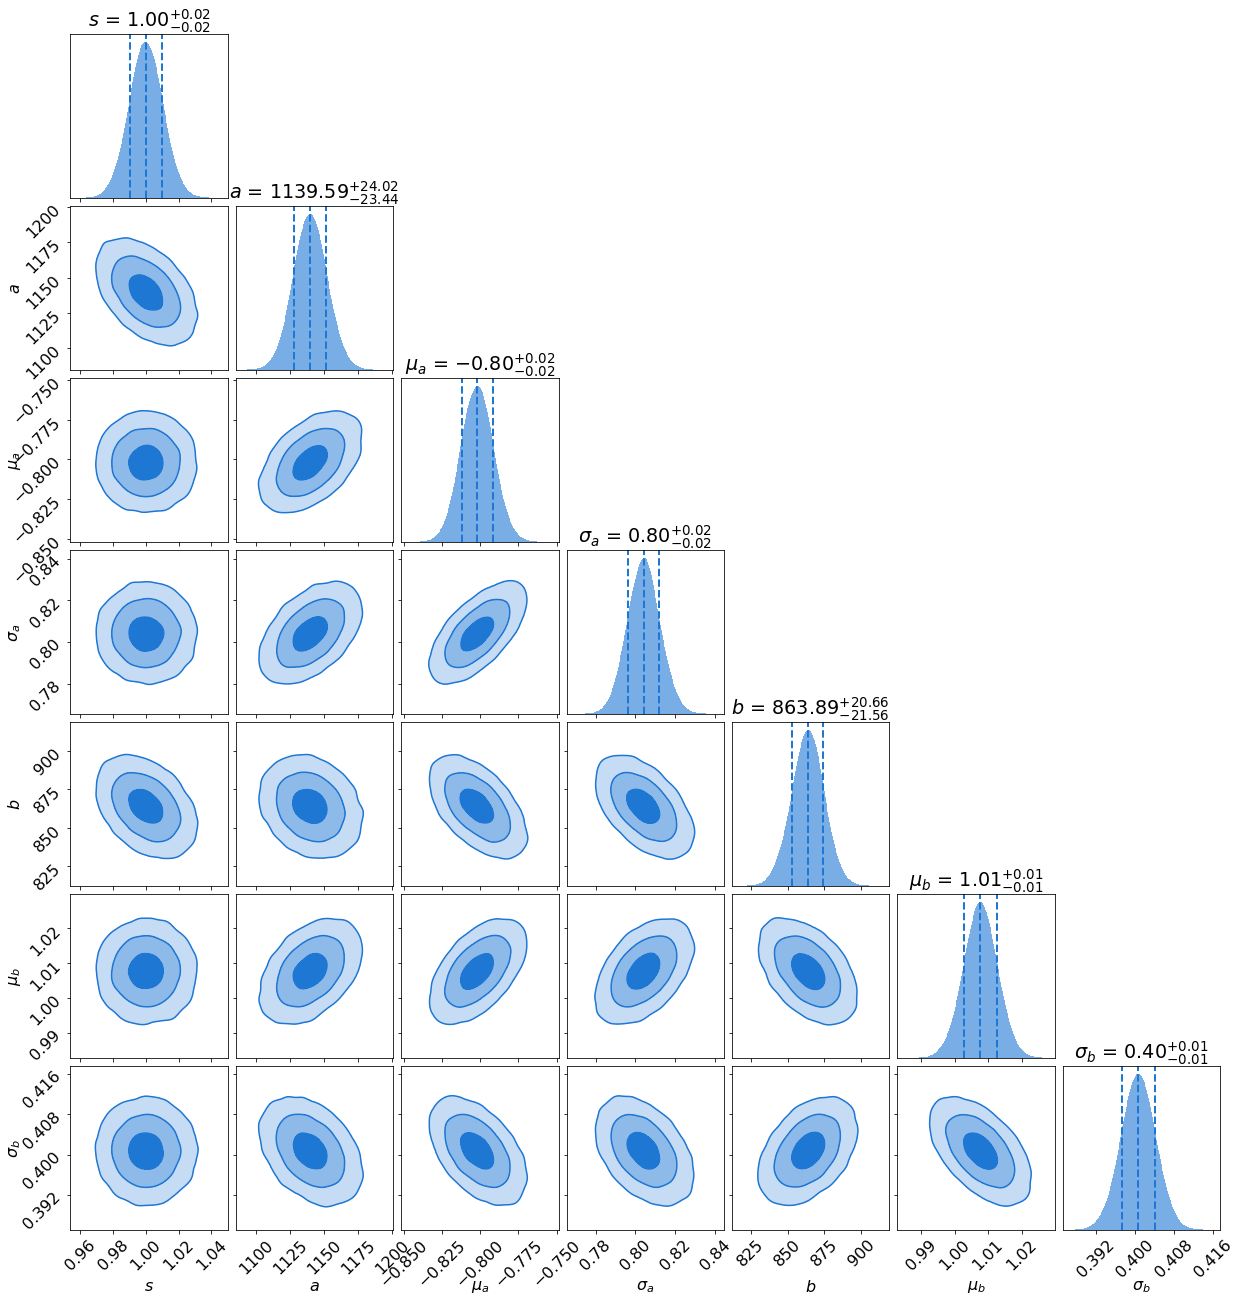

In [29]:
fig, axes = dyplot.cornerplot(dres1, smooth=0.03,
                              labels=labels,
                              show_titles=True,
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1.,2.,3]],
                              quantiles=[0.16, 0.5, 0.84],
                              fig=plt.subplots(7, 7, figsize=(2.5*7,2.6*7)),
                              color='#1f77d4')

#### Store the Bayesian Evidence

The nested sampler computes the logarithm of the Bayesian evidence $\ln{Z}$, where

$$
Z = p(\mathbf{m},\mathbf{n}|\mathcal{M}_1)
  = \int\mathrm{d}\vec{\theta}\ p(\mathbf{m},\mathbf{n}|\vec{\theta}, \mathcal{M}_1).
$$

That is, we obtain the evidence for the model $\mathcal{M}_1$ marginalizing over all parameter values $\vec{\theta}$ allowed by the prior. This term will be used later in the Bayes Factor.

In [30]:
lnzM1 = dres1.logz[-1]
lnzM1

-516.1541711396285

## Model $\mathcal{M}_2$: Two Parent Distribution

In this case assumed the data with binned counts $\mathbf{m}={m_i}$ and $\mathbf{n}={n_i}$ are created by separate Gaussian mixture models with mean count

$$
  \lambda_{1,i} = \left[\alpha\mathcal{N}(\mu_\alpha,\sigma_\alpha) + \beta\mathcal{N}(\mu_\beta,\sigma_\beta)\right]_i
$$

in set 1 and mean count

$$
  \lambda_{2,i} = \left[\left(\gamma\mathcal{N}(\mu_\gamma,\sigma_\gamma) + \delta\mathcal{N}(\mu_\delta,\sigma_\delta)\right)\right]_i
$$

in set 2.

Thus the model includes 12 free parameters $\theta=\left\{\alpha,\mu_\alpha,\sigma_\alpha,\beta,\mu_\beta,\sigma_\beta,\gamma,\mu_\gamma,\sigma_\gamma,\delta,\mu_\delta,\sigma_\delta\right\}$.

### Maximum Likelihood Result

As before, maximize the joint Poisson likelihood

$$
  p(\mathbf{m},\mathbf{n}|\lambda_1,\lambda_2,\mathcal{M_1})
  = \prod_{i=1}^N \frac{\lambda_{1,i}^{m_i}e^{-\lambda_{1,i}}}{m_i!}
  \frac{\lambda_{2,i}^{n_i}e^{-\lambda_{2,i}}}{n_i!},
$$

or minimize the negative log likelihood

$$
-\ln{\mathcal{L}} = -\sum_{i=1}^N \left(m_i\lambda_{1,i}-\lambda_{1,i}-\ln{m_i!} + 
n_i\lambda_{2,i}-\lambda_{2,i}-\ln{n_i!}\right).
$$

In [31]:
def logLjoint2(params, m, n, x):
    """Joint log-likelihood of the two data sets.
    
    Parameters
    ----------
    params : list or ndarray
        List of 12 parameters: 2x3x2 Gaussian components.
    m : ndarray
        Binned counts in data set 1.
    n : ndarray
        Binned counts in data set 2.
    x : ndarray
        Bin centers used to construct the histogrammed counts m and n.
        
    Returns
    -------
    logL : float
        Log likelihood of sets m and n given model parameters.
    """
    lambda1 = mixturemodel(params[:6], x)
    lambda2 = mixturemodel(params[6:], x)
    return np.sum(m*np.log(lambda1) - lambda1 - gammaln(m+1) + n*np.log(lambda2) - lambda2 - gammaln(n+1))

def nlogLjoint2(params, m, n, x):
    """Negative log likelihood, for minimizers."""
    return -logLjoint2(params, m, n, x)

#### Minimize the Log Likelihood

Minimize the log likelihood, using several different seeds.

In [32]:
bounds = [[500., 2000.],
          [-3., 0.],
          [0.1, 3.],
          [500., 2000.],
          [0., 3.],
          [0.1, 3.]]

bounds2 = bounds + bounds

bestfit = None

for i in range(10):
    p0 = [np.random.uniform(b[0], b[1]) for b in bounds2]
    result = minimize(nlogLjoint2, p0, method='L-BFGS-B', args=(n1, n2, x), bounds=bounds2)
    
    if result.success:
        print(p0)
        print('  {:.2f}'.format(result.fun))
        if bestfit is None:
            bestfit = result
        else:
            if result.fun < bestfit.fun:
                bestfit = result

bestfit

[1928.797155051774, -1.3437618712194621, 2.521383047645814, 1611.5163822970435, 2.793558968086367, 2.1284909636656315, 1497.8984459280532, -1.8865441445610134, 0.1065926460753076, 1875.2502276777686, 1.2990237342280007, 1.1585471293000864]
  444.86
[813.0841234076992, -2.108970356984185, 2.0610872922920045, 814.3712156346353, 1.1678900909610288, 1.3621369334134654, 1952.305717842159, -1.9401333057499521, 0.34489312074117134, 1852.520114258755, 1.8668013234056255, 0.7113593169880941]
  2630.00
[951.9851713347913, -1.6546875579002012, 1.6333078335480788, 1020.6890214487993, 2.351908275242865, 0.5415303794169438, 743.2513352819997, -1.9739828072358507, 2.1960438966267435, 1264.252179244399, 0.910124619499127, 2.3245902403833334]
  444.86
[1143.609392767057, -2.387050473369315, 1.6513638118142313, 1706.247205885561, 1.0155833529854212, 1.2494600562829532, 1388.8080402424127, -1.359102687096173, 1.3901220752172592, 632.9563019999499, 0.9398221660727674, 2.0956033631354316]
  444.86
[727.816

      fun: 444.8592170335271
 hess_inv: <12x12 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.66338121e-05,  4.17117008e-02,  2.38173925e-03, -1.87583282e-04,
       -1.26681243e-01, -1.01414344e-01, -8.52651283e-05, -2.09013251e-02,
        2.01680450e-02,  2.16004992e-04,  4.53610483e-03,  8.07290235e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 3874
      nit: 260
   status: 0
  success: True
        x: array([ 1.10249834e+03, -7.87490564e-01,  8.16484763e-01,  9.01184578e+02,
        1.00727549e+00,  3.99884135e-01,  1.17766109e+03, -8.14632230e-01,
        7.93058469e-01,  8.25770695e+02,  1.00832323e+00,  4.01252565e-01])

#### Plot the Best Fit

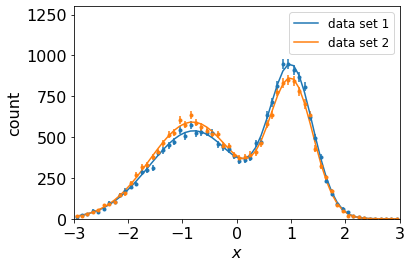

In [33]:
fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)

ep = ax.errorbar(x, n1, yerr=dn1, fmt='.')
ax.plot(x, mixturemodel(bestfit.x[:6], x), color=ep[0].get_color(), label='data set 1')

ep = ax.errorbar(x, n2, yerr=dn1, fmt='.');
ax.plot(x, mixturemodel(bestfit.x[6:], x), color=ep[0].get_color(), label='data set 2')

ax.set(xlim=(-3,3),
       xlabel='$x$',
       ylim=(0, 1300),
       ylabel='count')

ax.legend(fontsize=12);

### Nested Sampling of the $\mathcal{M}_2$ Likelihood and Priors

In [34]:
def prior_xform2(u):
    a       = jeffreys(1., 1e4, u[0])
    mu_a    = uniform(-3., 0., u[1])
    sigma_a = jeffreys(0.1, 1., u[2])
    b       = jeffreys(1., 1e4, u[3])
    mu_b    = uniform(0., 3., u[4])
    sigma_b = jeffreys(0.1, 1., u[5])
    
    c       = jeffreys(1., 1e4, u[6])
    mu_c    = uniform(-3., 0., u[7])
    sigma_c = jeffreys(0.1, 1., u[8])
    d       = jeffreys(1., 1e4, u[9])
    mu_d    = uniform(0., 3., u[10])
    sigma_d = jeffreys(0.1, 1., u[11])
    
    return a, mu_a, sigma_a, b, mu_b, sigma_b, c, mu_c, sigma_c, d, mu_d, sigma_d

In [35]:
dsampler = dynesty.DynamicNestedSampler(logLjoint2, prior_xform2, ndim=12,
                                        logl_args=(n1, n2, x),
                                        nlive=3000,
                                        bound='multi',
                                        sample='auto')

dsampler.run_nested()
dres2 = dsampler.results

8529it [02:14, 60.59it/s, batch: 0 | bound: 102 | nc: 25 | ncall: 187485 | eff(%):  4.537 | loglstar:   -inf < -4361.783 <    inf | logz: -4384.703 +/-  0.299 | dlogz: 2958.718 >  0.010]   /Users/sybenzvi/.local/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
9973it [02:41, 61.30it/s, batch: 0 | bound: 125 | nc: 25 | ncall: 227161 | eff(%):  4.381 | loglstar:   -inf < -2852.729 <    inf | logz: -2878.953 +/-  0.316 | dlogz: 1484.095 >  0.010] /Users/sybenzvi/.local/lib/python3.7/site-packages/dynesty/sampling.py:238: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
/Users/sybenzvi/.local/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extrem

#### Corner Plot of the Nested Sampling Results

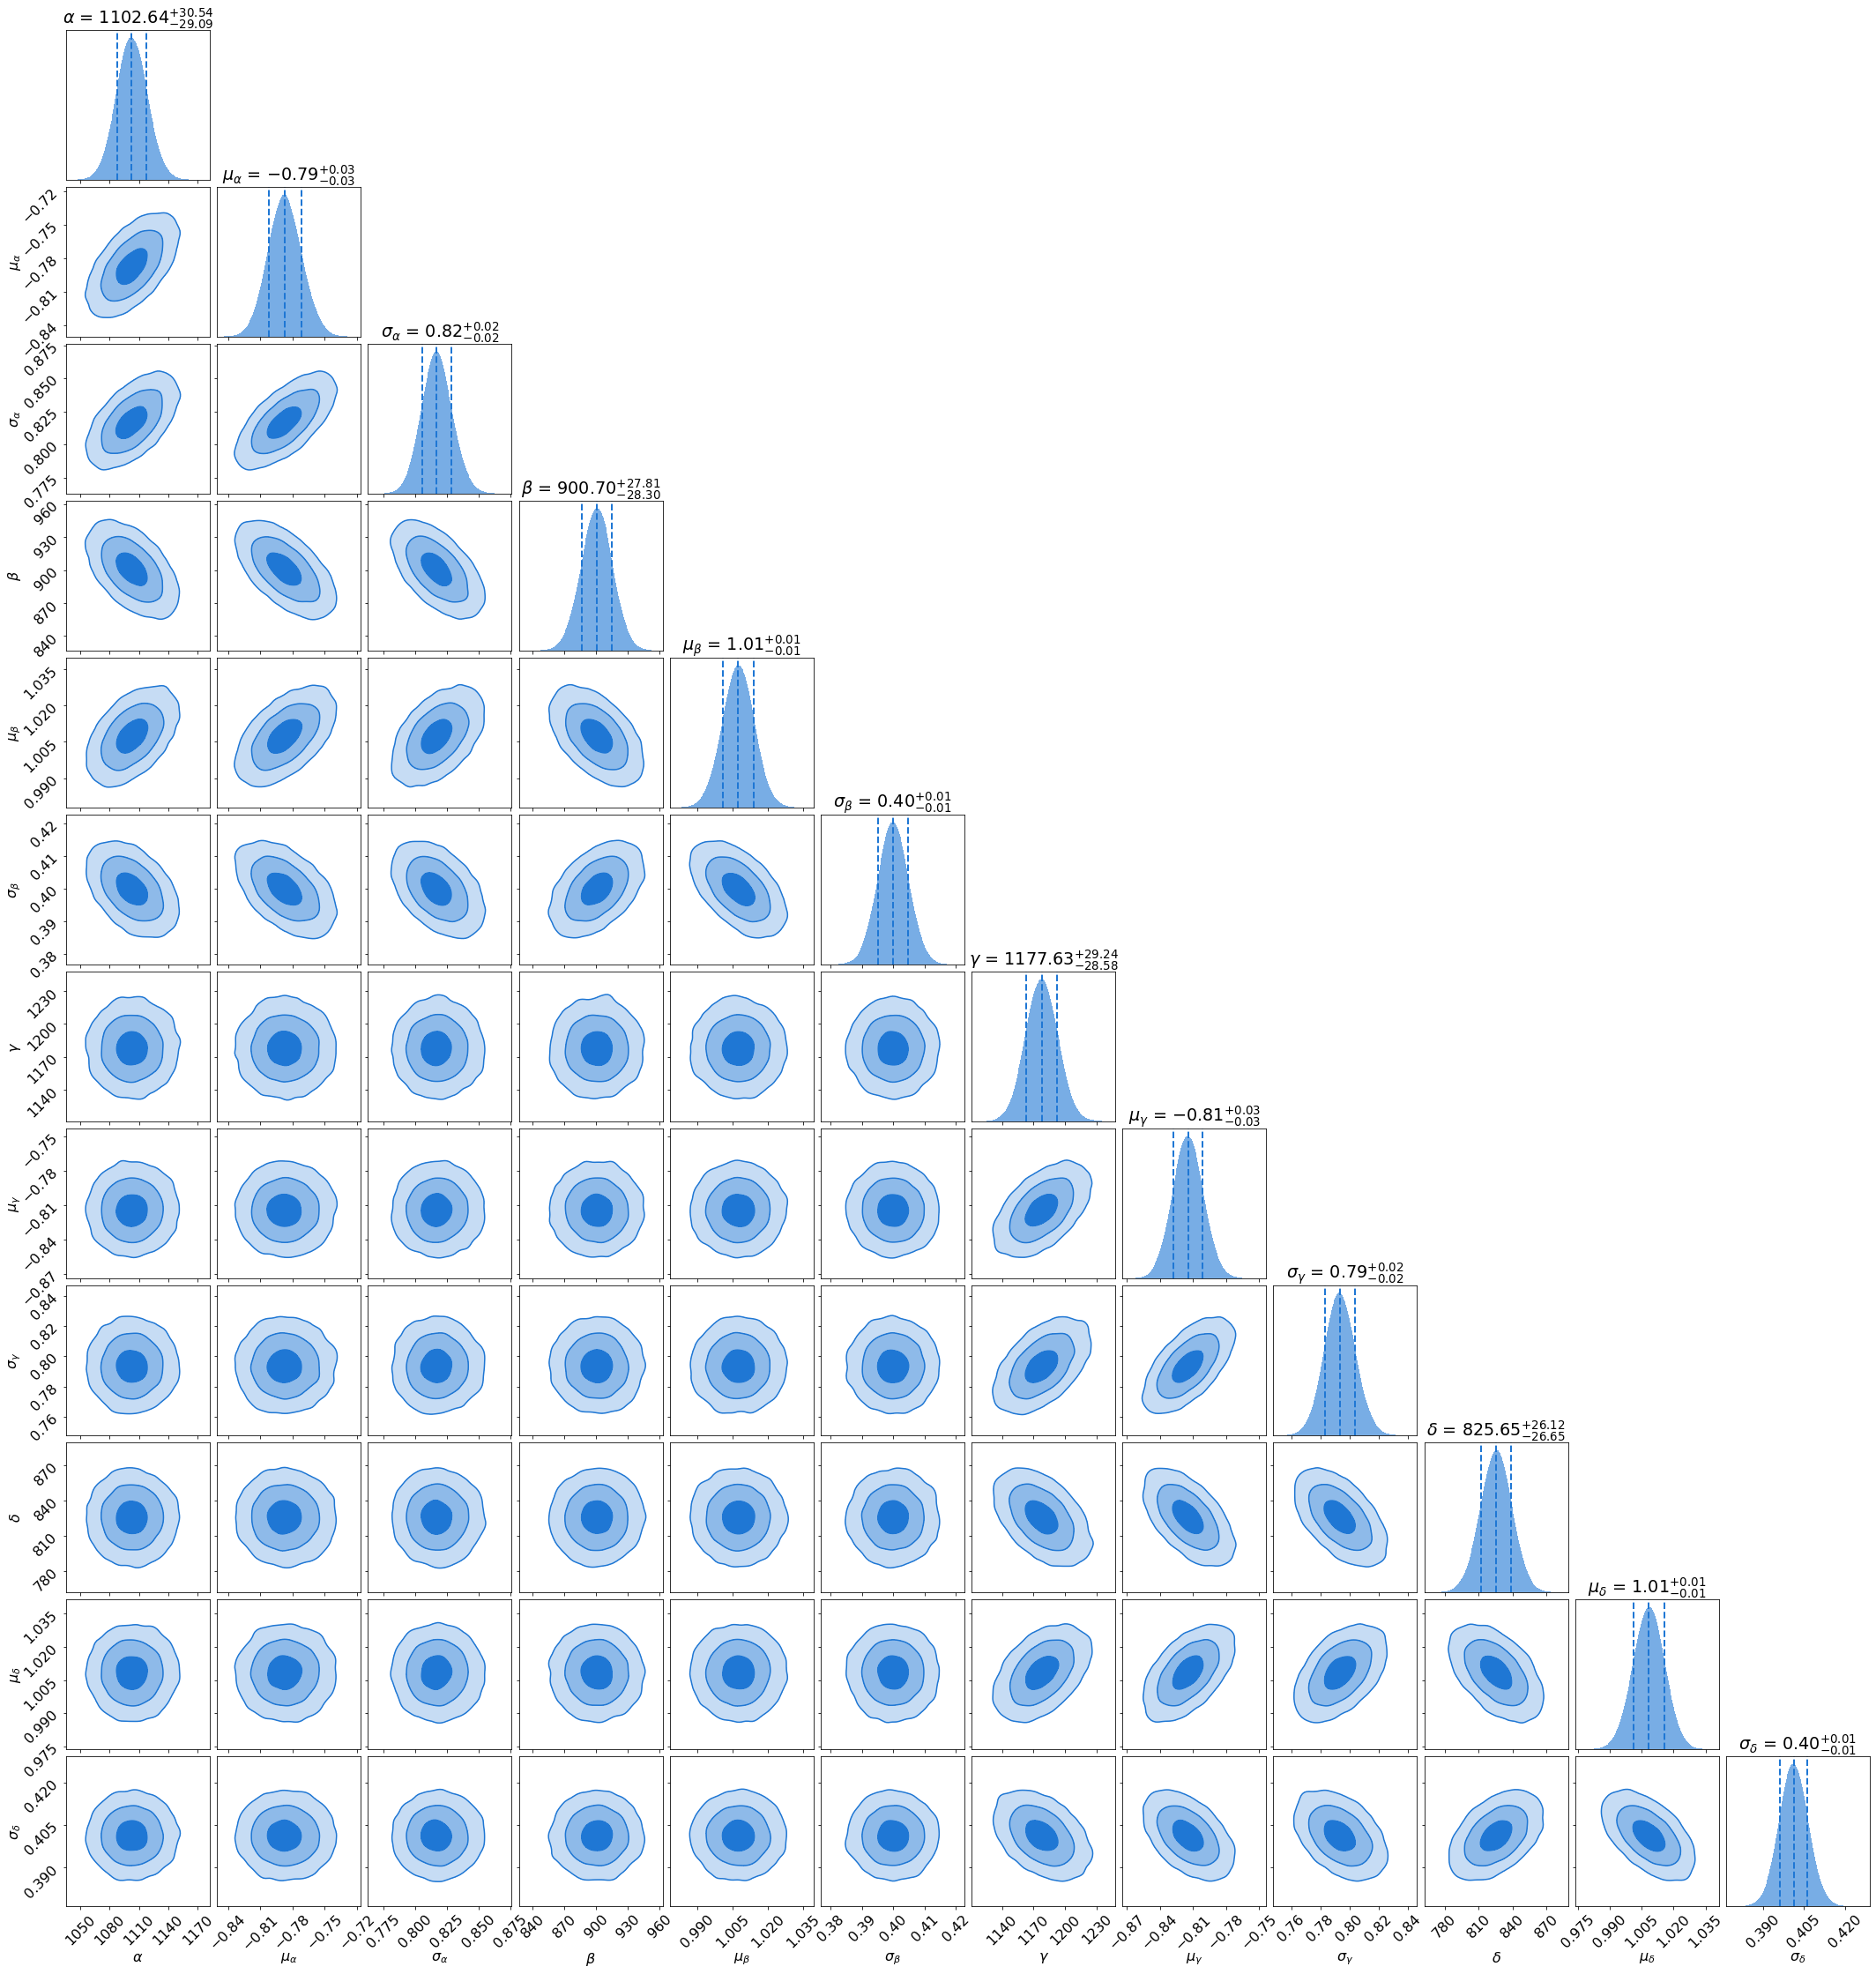

In [36]:
labels = [r'$\alpha$', r'$\mu_{\alpha}$', r'$\sigma_{\alpha}$',
          r'$\beta$',  r'$\mu_{\beta}$',  r'$\sigma_{\beta}$',
          r'$\gamma$', r'$\mu_{\gamma}$', r'$\sigma_{\gamma}$',
          r'$\delta$', r'$\mu_{\delta}$', r'$\sigma_{\delta}$']

fig, axes = dyplot.cornerplot(dres2, smooth=0.03,
#                               title_kwargs={'y': 1.03},
                              labels=labels,
#                               truths=xmax,
                              show_titles=True,
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1.,2.,3]],
                              quantiles=[0.16, 0.5, 0.84],
                              fig=plt.subplots(12, 12, figsize=(2.5*12,2.6*12)),
                              color='#1f77d4')

In [37]:
lnzM2 = dres2.logz[-1]
lnzM2

-504.4942938453416

## Bayes Factor

The Bayes Factor giving the odds ratio of the two models is

$$
\ln{B_{12}} = \ln{\left(\frac{p(\mathbf{m},\mathbf{n}|\mathcal{M}_1)}{p(\mathbf{m},\mathbf{n}|\mathcal{M}_2)}\right)}
= \ln{Z_1} - \ln{Z_2}
$$

In [38]:
lnB12 = lnzM1 - lnzM2
lnB12

-11.6598772942869

In [39]:
B12 = np.exp(lnB12)
print('B12 = {:.3g}; log(B12) = {:.3g}'.format(B12, np.log10(B12)))

B12 = 8.63e-06; log(B12) = -5.06


Thus model $\mathcal{M}_2$, in which the two data sets come from different parent distribution, is overwhelmingly favored by a ratio of $10^6$:$1$.